# A - Making Price Predictions for One Week

## Install and Import Libraries

In [1]:
!pip install --upgrade pandas-datareader

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math

import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

## Download Data
We chose Apple Inc. (AAPL) stock for this question.

In [3]:
# Download AAPL stock data from Yahoo
aapl_df = web.DataReader('AAPL', 'yahoo', start='2012-01-01', end='2022-03-25')
aapl_df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,14.732143,14.607143,14.621429,14.686786,302220800.0,12.575918
2012-01-04,14.810000,14.617143,14.642857,14.765714,260022000.0,12.643497
2012-01-05,14.948214,14.738214,14.819643,14.929643,271269600.0,12.783872
2012-01-06,15.098214,14.972143,14.991786,15.085714,318292800.0,12.917512
2012-01-09,15.276786,15.048214,15.196429,15.061786,394024400.0,12.897023
...,...,...,...,...,...,...
2022-03-21,166.350006,163.009995,163.509995,165.380005,95811400.0,165.380005
2022-03-22,169.419998,164.910004,165.509995,168.820007,81532000.0,168.820007
2022-03-23,172.639999,167.649994,167.990005,170.210007,98062700.0,170.210007


## Visualize Data

Text(0, 0.5, 'Stock Price ($)')

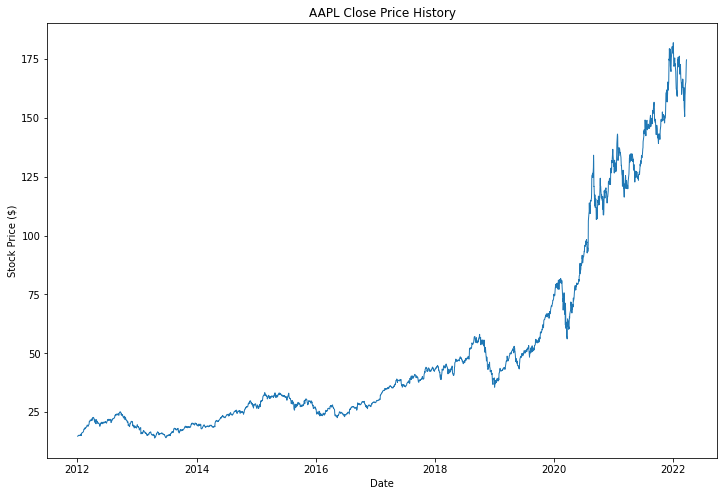

In [4]:
plt.figure(figsize=(12,8))
plt.title('AAPL Close Price History')
plt.plot(aapl_df['Close'], lw=1)
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')

## Data Preparation

In [5]:
# Only focus on the closing price data
data = aapl_df.filter(['Close'])

In [6]:
# Put data in a numpy array. Training set is set to be 80% of data 
train_pct = 0.8  
dataset = data.values
train_data_len = math.ceil(len(dataset)*train_pct)

In [7]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [8]:
# Window size (n_period) is the input
n_period = 60

# Make training dataset
train_data = scaled_data[0:train_data_len]
x_train = []
y_train = []

for i in range(n_period, len(train_data)):
    x_train.append(train_data[i-n_period:i,0])
    y_train.append(train_data[i,0])

In [9]:
# Convert x_train and y_train to Numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape x_train for LSTM model training
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

## LSTM Model
Train a LSTM model with the `Adam` optimizer and `mean_squared_error` loss function.

### Train the model with training dataset 

In [10]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [11]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error') 

In [12]:
# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

2000/2000 [==============================] - 84s 38ms/step - loss: 2.3230e-04


### Evaluate the model with test dataset

In [13]:
# Make test dataset
test_data = scaled_data[train_data_len-n_period:,:]
x_test = []
y_test = dataset[train_data_len:,:]

for i in range(n_period, len(test_data)):
    x_test.append(test_data[i-n_period:i,0])
    
# Reshape x_test to be a compatible LSTM model input               
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [14]:
# Make predictions with test dataset and revert back to original scale
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [18]:
# Calculate prediction evaluation metric (RMSE)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
print(f"The RMSE of the predicted prices is {rmse:.4f}")

The RMSE of the predicted prices is 14.1524


In [19]:
# Make training and validation datasets for visualization
train = data[:train_data_len] # first 80% of data in dataframe

valid = data[train_data_len:] # last 20% of data in dataframe
valid = valid.assign(Predictions=predictions) # add 'Predictions' column to valid dataframe

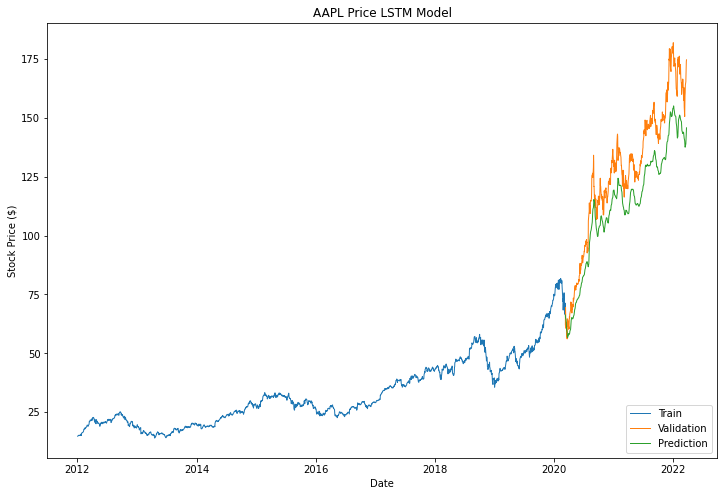

In [20]:
# Visualize training, validation, and predicted prices
plt.figure(figsize=(12,8))
plt.title('AAPL Price LSTM Model')
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')
plt.plot(train['Close'], lw=1)
plt.plot(valid[['Close', 'Predictions']], lw=1)
plt.legend(['Train', 'Validation', 'Prediction'], loc='lower right')
plt.show()

### Price Predictions for One Week Using Past 60 Days Data

In [21]:
# Get closing price data from last 60 days
last_60_days = data[-60:].values
last_60days_scaled = scaler.transform(last_60_days)

In [22]:
# Make last 60 days data to be a compatible input format for model
X_test = []
X_test.append(last_60days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

To predict prices using the data of the past 60 days, the preceding predicted price(s) are used as data when applicable.

For example, predicting the price for the 3rd day of the week includes the actual price data for the past 58 days and the predicted prices for the 1st and 2nd day of the week in the LSTM model.

In [23]:
# Predict prices for one week (March 28 - April 1, 2022)
predicted_prices = []

for _ in range(5):
  # predict price for each day and store in predicted_prices array
  predicted_price = model.predict(X_test)
  predicted_prices.append(scaler.inverse_transform(predicted_price))

  # add new predicted price to X_test to use in subsequent predictions
  predicted_price = np.reshape(predicted_price, (1, 1, 1))
  X_test = np.append(X_test, predicted_price, axis=1)
  X_test = X_test[:, 1:, ]

In [24]:
# Put predicted prices into a dataframe
dates_for_prediction = ['2022-03-28', '2022-03-29', '2022-03-30', '2022-03-31', '2022-04-01']
predicted_prices = [price[0] for price in predicted_prices]

predicted_prices_df = pd.DataFrame(predicted_prices, index=dates_for_prediction, columns=['Predicted AAPL Share Price'])
predicted_prices_df.index.name = 'Date'
predicted_prices_df

,Predicted AAPL Share Price
Date,
2022-03-28,147.687637
2022-03-29,146.006989
2022-03-30,142.840958
2022-03-31,139.002457
2022-04-01,134.936722


In [25]:
# Retrieve actual closing AAPL prices for March 28 - April 1, 2022
actual_week_data = web.DataReader('AAPL', 'yahoo', '2022-03-28', '2022-04-01')
actual_week_data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-03-28,175.729996,172.000000,172.169998,175.600006,90371900,175.600006
2022-03-29,179.009995,176.339996,176.690002,178.960007,100589400,178.960007
2022-03-30,179.610001,176.699997,178.550003,177.770004,92633200,177.770004
2022-03-31,178.029999,174.399994,177.839996,174.610001,103049300,174.610001
2022-04-01,174.880005,171.940002,174.029999,174.309998,78699800,174.309998


# B - Trading Signals

Price predictions (stored in `predictions` array) for the testing data were generated for last 515 days (testing period) of January 1, 2012 - March 25, 2022 time period.

We use the ***Open*** price of the trading day as our price threshold to determine whether to buy or short a share. Under typical circumstances, trading can only be done during when markets are open. Thus, we determine the course of action we will take for the trading day when the markets open based on our closing price prediction. We compare the open price to our predicted closing price of the trading day of interest and determine whether buying or shorting a share is most profitable.

\\
**Example 1:** \\
Predicted closing price for March 25, 2022:  **\$100** \\
Actual open price on March 25, 2022:  **\$90** \\
Trading signal: **Buy a share**

**Example 2:** \\
Predicted closing price for March 25, 2022:  **\$100** \\
Actual open price on March 25, 2022:  **\$110** \\
Trading signal: **Short a share**

In [26]:
# Function to determine which action to take
def determine_action(open_price, predicted_price):
  if open_price <= predicted_price:
    return 'Buy'
  else:
    return 'Short'

In [27]:
# Make trading signals dataframe with corresponding predictions and actual open prices
trading_signals_df = pd.DataFrame(aapl_df['Open'].iloc[-515:,])
trading_signals_df['Predicted'] = np.ravel(predictions)

# Add action to take based on open and predicted closing prices to trading signals dataframe
trading_signals_df['Trading Signal'] = trading_signals_df.apply(lambda x: determine_action(x['Open'], x['Predicted']), axis=1)
trading_signals_df

,Open,Predicted,Trading Signal
Date,,,
2020-03-12,63.985001,66.242043,Buy
2020-03-13,66.222504,64.986160,Short
2020-03-16,60.487499,64.349159,Buy
2020-03-17,61.877499,63.097923,Buy
2020-03-18,59.942501,62.005001,Buy
...,...,...,...
2022-03-21,163.509995,139.024979,Short
2022-03-22,165.509995,140.361618,Short
2022-03-23,167.990005,142.056534,Short


# C - Accumulated Profit-and-Loss for Testing Data

As stated in the assignment, we assume that we always close our position after one week, which is equal to every 5 trading days.

We initiate a position at the start of the week (day 1) and keep it until the end of the week (day 5). The position that is initiated is based on the trading signal of day 1. The open price of day 1 is the price at which a position is initiated and the close price of day 5 is the price at which the position is closed.

We will only be dealing with one share in profit-and-loss calculations.

\\
**Price difference formula:** \\
*Day 5 Close Price - Day 1 Open Price*

\\
If the trading signal is *'Buy'*:
- A positive difference means profit
- A negative difference means loss

\\
If the trading signal is *'Short'*:
- A positive difference means loss
- A negative difference means profit


In [28]:
# Get the actual Open and Close prices for the testing period
actual_prices = aapl_df[['Open', 'Close']].iloc[-515:,]
actual_prices

,Open,Close
Date,,
2020-03-12,63.985001,62.057499
2020-03-13,66.222504,69.492500
2020-03-16,60.487499,60.552502
2020-03-17,61.877499,63.215000
2020-03-18,59.942501,61.667500
...,...,...
2022-03-21,163.509995,165.380005
2022-03-22,165.509995,168.820007
2022-03-23,167.990005,170.210007


In [29]:
# Make dataframe with day 1 open price, day 5 close price, trading signal
weekly_data_df = pd.DataFrame(zip(actual_prices['Open'].iloc[::5].values,
                                actual_prices['Close'].iloc[4::5].values,
                                trading_signals_df['Trading Signal'].iloc[::5].values),
                              columns=['Day 1 Open', 'Day 5 Close', 'Trading Signal'])

weekly_data_df.index.name = 'Week'
weekly_data_df.index += 1
weekly_data_df

,Day 1 Open,Day 5 Close,Trading Signal
Week,,,
1,63.985001,61.667500,Buy
2,61.847500,61.380001,Short
3,61.630001,60.227501,Short
4,60.084999,66.517502,Short
5,67.175003,71.672501,Short
...,...,...,...
99,169.820007,164.850006,Short
100,163.059998,163.169998,Short
101,163.360001,154.729996,Short


In [30]:
# Function to calculate profit/loss based on trading signal
def calculate_profit_loss(open_price, close_price, signal):
  if signal == 'Buy':
    return close_price - open_price

  elif signal == 'Short':
    return open_price - close_price

In [31]:
# Calculate PnL for each week
weekly_pnl_df = weekly_data_df.apply(lambda x: calculate_profit_loss(x['Day 1 Open'], x['Day 5 Close'], x['Trading Signal']), axis=1)
weekly_pnl_df

Week
1      -2.317501
2       0.467499
3       1.402500
4      -6.432503
5      -4.497498
         ...    
99      4.970001
100    -0.110001
101     8.630005
102   -12.529999
103   -11.210007
Length: 103, dtype: float64

In [32]:
# Calculate and print final accumuluated PnL
accumulated_pnl = weekly_pnl_df.sum()

if accumulated_pnl >= 0:
  print(f"Our final accumulated profit is ${accumulated_pnl:.2f}.")
else:
  print(f"Our final accumulated loss is ${abs(accumulated_pnl):.2f}.")

Our final accumulated loss is $100.60.


# D - Predicting Prices by Including Historical S&P 500 Data

## Make Price Predictions for One Week

In [33]:
# Import hisotrical S&P500 index (^GSPC) data
sp500_df = web.DataReader('^GSPC', 'yahoo', start='2012-01-01', end='2022-03-25')
sp500_df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,1284.619995,1258.859985,1258.859985,1277.060059,3943710000,1277.060059
2012-01-04,1278.729980,1268.099976,1277.030029,1277.300049,3592580000,1277.300049
2012-01-05,1283.050049,1265.260010,1277.300049,1281.060059,4315950000,1281.060059
2012-01-06,1281.839966,1273.339966,1280.930054,1277.810059,3656830000,1277.810059
2012-01-09,1281.989990,1274.550049,1277.829956,1280.699951,3371600000,1280.699951
...,...,...,...,...,...,...
2022-03-21,4481.750000,4424.299805,4462.399902,4461.180176,3961050000,4461.180176
2022-03-22,4522.000000,4469.100098,4469.100098,4511.609863,3962880000,4511.609863
2022-03-23,4501.069824,4455.810059,4493.100098,4456.240234,4014360000,4456.240234


In [34]:
# Only focus on the closing S&P500 index data
sp500_data = sp500_df.filter(['Close'])

In [35]:
aapl_sp500_df = pd.concat([data, sp500_data], axis=1) # concatenate with AAPL close price data from part A
aapl_sp500_df.columns = ['AAPL Close', 'S&P500 Close']
aapl_sp500_df

,AAPL Close,S&P500 Close
Date,,
2012-01-03,14.686786,1277.060059
2012-01-04,14.765714,1277.300049
2012-01-05,14.929643,1281.060059
2012-01-06,15.085714,1277.810059
2012-01-09,15.061786,1280.699951
...,...,...
2022-03-21,165.380005,4461.180176
2022-03-22,168.820007,4511.609863
2022-03-23,170.210007,4456.240234


In [36]:
# Put data in a numpy array. Training set is set to be 80% of data 
train_pct = 0.8
aapl_sp500_dataset = aapl_sp500_df.values
train_data_len = math.ceil(len(aapl_sp500_dataset)*train_pct)

In [37]:
# Scale the data
aapl_sp500_scaler = MinMaxScaler(feature_range=(0,1))
scaled_aapl_sp500 = aapl_sp500_scaler.fit_transform(aapl_sp500_dataset)

In [38]:
# Window size (n_period) is the input
n_period = 60

# Make training dataset
train_data = scaled_aapl_sp500[0:train_data_len]
x_train = []
y_train = []

for i in range(n_period, len(train_data)):
    x_train.append(train_data[i-n_period:i,])
    y_train.append(train_data[i,])

In [39]:
# Convert x_train and y_train to Numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape x_train for LSTM model training
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 2)) # dimension of 2 since there is another training data column (S&P500 data)

### Train the LSTM model with the training dataset that includes S&P500 index data

In [40]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 2)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(2)) # 2 neurons as output because we need the AAPL share price and price of S&P500 index to be able to predict AAPL prices for one week

In [41]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [42]:
# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

2000/2000 [==============================] - 64s 31ms/step - loss: 5.1893e-04


### Evaluate the model with test dataset

In [43]:
# Make test dataset
test_data = scaled_aapl_sp500[train_data_len-n_period:,:]
x_test = []
y_test = aapl_sp500_dataset[train_data_len:,:]

for i in range(n_period, len(test_data)):
    x_test.append(test_data[i-n_period:i,])
    
# Reshape x_test to be a compatible LSTM model input               
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 2))

In [44]:
# Make predictions with test dataset and revert back to original scale
predictions = model.predict(x_test)
predictions = aapl_sp500_scaler.inverse_transform(predictions)

In [48]:
# Calculate prediction evaluation metric (RMSE) for AAPL
rmse = np.sqrt(np.mean(predictions[:,0] - y_test[:,0])**2)
print(f"The RMSE of the predicted prices is {rmse:.4f}")

The RMSE of the predicted prices is 2.8517


In [49]:
# Make training and validation datasets for visualization
train = data[:train_data_len] # first 80% of data in dataframe

valid = data[train_data_len:] # last 20% of data in dataframe
valid = valid.assign(Predictions=predictions[:,0]) # add AAPL price predictions column to valid dataframe

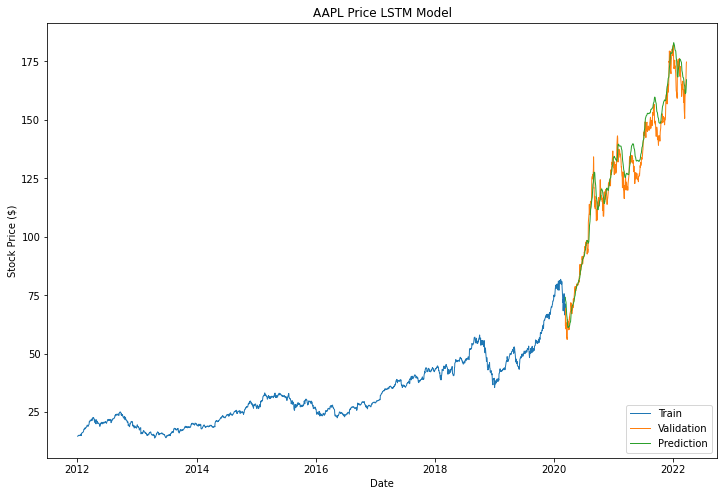

In [50]:
# Visualize training, validation, and predicted prices
plt.figure(figsize=(12,8))
plt.title('AAPL Price LSTM Model')
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')
plt.plot(train['Close'], lw=1)
plt.plot(valid[['Close', 'Predictions']], lw=1)
plt.legend(['Train', 'Validation', 'Prediction'], loc='lower right')
plt.show()

### Price Predictions for One Week Using Past 60 Days Data

In [51]:
# Get closing price data from last 60 days
last_60_days = aapl_sp500_df.iloc[-60:,].values
last_60days_scaled = aapl_sp500_scaler.transform(last_60_days)

In [52]:
# Make last 60 days data to be a compatible input format for model
X_test = []
X_test.append(last_60days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 2))

In [53]:
# Predict AAPL prices for one week (March 28 - April 1, 2022)
predicted_prices = []

for _ in range(5):
  # predict price for each day and store in predicted_prices array
  prediction = model.predict(X_test)
  original_scale_prediction = aapl_sp500_scaler.inverse_transform(prediction)
  predicted_prices.append(original_scale_prediction[0][0])

  # add new predicted price to X_test to use in subsequent predictions
  prediction = np.reshape(prediction, (1, 1, 2))
  X_test = np.append(X_test, prediction, axis=1)
  X_test = X_test[:, 1:, ]

In [54]:
# Put predicted prices into a dataframe
dates_for_prediction = ['2022-03-28', '2022-03-29', '2022-03-30', '2022-03-31', '2022-04-01']
predicted_prices = [price for price in predicted_prices]

predicted_prices_df = pd.DataFrame(predicted_prices, index=dates_for_prediction, columns=['Predicted AAPL Share Price'])
predicted_prices_df.index.name = 'Date'
predicted_prices_df

,Predicted AAPL Share Price
Date,
2022-03-28,169.124222
2022-03-29,170.421173
2022-03-30,171.444702
2022-03-31,172.235016
2022-04-01,172.833633


### Generate Trading Signals

Using the same reasoning as part B, we generate trading signals for the testing period with the S&P500 index data included.

In [55]:
# Make trading signals dataframe with corresponding predictions and actual open prices
trading_signals_df = pd.DataFrame(aapl_df['Open'].iloc[-515:,])
trading_signals_df['Predicted'] = np.ravel(predictions[:,0])

# Add action to take based on open and predicted closing prices to trading signals dataframe
trading_signals_df['Trading Signal'] = trading_signals_df.apply(lambda x: determine_action(x['Open'], x['Predicted']), axis=1)
trading_signals_df

,Open,Predicted,Trading Signal
Date,,,
2020-03-12,63.985001,74.118065,Buy
2020-03-13,66.222504,72.928543,Buy
2020-03-16,60.487499,72.039299,Buy
2020-03-17,61.877499,70.698669,Buy
2020-03-18,59.942501,69.392410,Buy
...,...,...,...
2022-03-21,163.509995,161.644394,Short
2022-03-22,165.509995,162.466873,Short
2022-03-23,167.990005,163.755569,Short


### Calculate Final Acculumated PnL

We follow the same reasoning outlined in part C to calculate the final accumulated PnL.

In [56]:
# Make dataframe with day 1 open price of AAPL, day 5 close price of AAPL, day 1 trading signal
weekly_data_df = pd.DataFrame(zip(actual_prices['Open'].iloc[::5].values,
                                actual_prices['Close'].iloc[4::5].values,
                                trading_signals_df['Trading Signal'].iloc[::5].values),
                              columns=['Day 1 Open', 'Day 5 Close', 'Day 1 Trading Signal'])

weekly_data_df.index.name = 'Week'
weekly_data_df.index += 1
weekly_data_df

,Day 1 Open,Day 5 Close,Day 1 Trading Signal
Week,,,
1,63.985001,61.667500,Buy
2,61.847500,61.380001,Buy
3,61.630001,60.227501,Buy
4,60.084999,66.517502,Buy
5,67.175003,71.672501,Short
...,...,...,...
99,169.820007,164.850006,Buy
100,163.059998,163.169998,Buy
101,163.360001,154.729996,Buy


In [57]:
# Calculate PnL for each week
weekly_pnl_df = weekly_data_df.apply(lambda x: calculate_profit_loss(x['Day 1 Open'], x['Day 5 Close'], x['Day 1 Trading Signal']), axis=1)
weekly_pnl_df

Week
1      -2.317501
2      -0.467499
3      -1.402500
4       6.432503
5      -4.497498
         ...    
99     -4.970001
100     0.110001
101    -8.630005
102    12.529999
103   -11.210007
Length: 103, dtype: float64

In [58]:
# Calculate and print final accumuluated PnL
accumulated_pnl = weekly_pnl_df.sum()

if accumulated_pnl >= 0:
  print(f"Our final accumulated profit is ${accumulated_pnl:.2f}.")
else:
  print(f"Our final accumulated loss is ${abs(accumulated_pnl):.2f}.")

Our final accumulated profit is $65.77.


# E - Predicting Prices by Including Another Variable

## Make Price Predictions for One Week

Adding to the model in part D, we will also include the difference between AAPL's day high and low prices in the prediction LSTM model.

In [59]:
aapl_df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,14.732143,14.607143,14.621429,14.686786,302220800.0,12.575918
2012-01-04,14.810000,14.617143,14.642857,14.765714,260022000.0,12.643497
2012-01-05,14.948214,14.738214,14.819643,14.929643,271269600.0,12.783872
2012-01-06,15.098214,14.972143,14.991786,15.085714,318292800.0,12.917512
2012-01-09,15.276786,15.048214,15.196429,15.061786,394024400.0,12.897023
...,...,...,...,...,...,...
2022-03-21,166.350006,163.009995,163.509995,165.380005,95811400.0,165.380005
2022-03-22,169.419998,164.910004,165.509995,168.820007,81532000.0,168.820007
2022-03-23,172.639999,167.649994,167.990005,170.210007,98062700.0,170.210007


In [60]:
# Calculate difference between day high and low prices
high_low_difference = aapl_df['High'] - aapl_df['Low']

# Append difference column to AAPL and S&P500 closing prices dataframe
difference_df = pd.concat([aapl_sp500_df, high_low_difference], axis=1)
difference_df.columns = ['AAPL Close', 'S&P500 Close', 'High Low Difference']
difference_df

,AAPL Close,S&P500 Close,High Low Difference
Date,,,
2012-01-03,14.686786,1277.060059,0.125000
2012-01-04,14.765714,1277.300049,0.192858
2012-01-05,14.929643,1281.060059,0.210000
2012-01-06,15.085714,1277.810059,0.126071
2012-01-09,15.061786,1280.699951,0.228572
...,...,...,...
2022-03-21,165.380005,4461.180176,3.340012
2022-03-22,168.820007,4511.609863,4.509995
2022-03-23,170.210007,4456.240234,4.990005


In [61]:
# Put data in a numpy array. Training set is set to be 80% of data 
train_pct = 0.8
dataset_with_difference = difference_df.values
train_data_len = math.ceil(len(dataset_with_difference)*train_pct)

In [62]:
# Scale the data
difference_scaler = MinMaxScaler(feature_range=(0,1))
scaled_difference_dataset = difference_scaler.fit_transform(dataset_with_difference)

In [63]:
# Window size (n_period) is the input
n_period = 60

# Make training dataset
train_data = scaled_difference_dataset[0:train_data_len]
x_train = []
y_train = []

for i in range(n_period, len(train_data)):
    x_train.append(train_data[i-n_period:i,])
    y_train.append(train_data[i,])

In [64]:
# Convert x_train and y_train to Numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape x_train for LSTM model training
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 3)) # dimension of 3 since there are AAPL price, S&P500 index, and high-low difference data in the training data

### Train the LSTM model with the new training dataset

In [65]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 3)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(3)) # 3 neurons as output because we need the AAPL share price, price of S&P500 index, and high-low difference to be able to predict AAPL prices for one week

In [66]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [67]:
# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

2000/2000 [==============================] - 63s 29ms/step - loss: 6.3668e-04


### Evaluate the model with test dataset

In [68]:
# Make test dataset
test_data = scaled_difference_dataset[train_data_len-n_period:,:]
x_test = []
y_test = dataset_with_difference[train_data_len:,:]

for i in range(n_period, len(test_data)):
    x_test.append(test_data[i-n_period:i,])
    
# Reshape x_test to be a compatible LSTM model input               
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 3))

In [69]:
# Make predictions with test dataset and revert back to original scale
predictions = model.predict(x_test)
predictions = difference_scaler.inverse_transform(predictions)

In [72]:
# Calculate prediction evaluation metric (RMSE) for AAPL
rmse = np.sqrt(np.mean(predictions[:,0] - y_test[:,0])**2)
print(f"The RMSE of the predicted prices is {rmse:.4f}")

The RMSE of the predicted prices is 1.3811


In [73]:
# Make training and validation datasets for visualization
train = data[:train_data_len] # first 80% of data in dataframe

valid = data[train_data_len:] # last 20% of data in dataframe
valid = valid.assign(Predictions=predictions[:,0]) # add AAPL price predictions column to valid dataframe

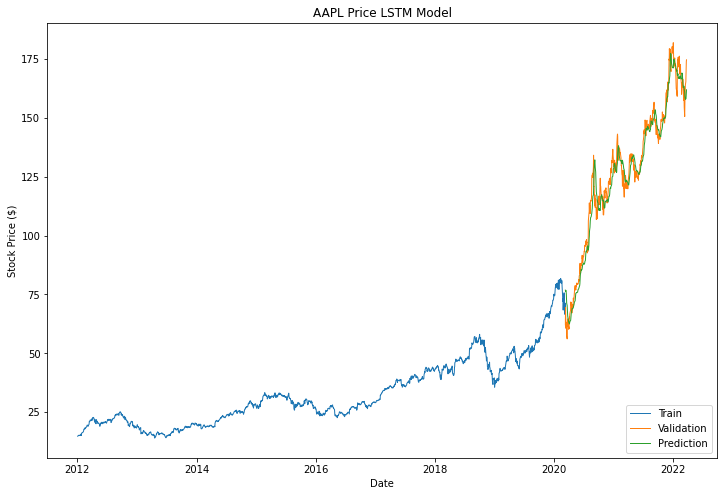

In [74]:
# Visualize training, validation, and predicted prices
plt.figure(figsize=(12,8))
plt.title('AAPL Price LSTM Model')
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')
plt.plot(train['Close'], lw=1)
plt.plot(valid[['Close', 'Predictions']], lw=1)
plt.legend(['Train', 'Validation', 'Prediction'], loc='lower right')
plt.show()

### Price Predictions for One Week Using Past 60 Days Data

In [75]:
# Get closing price data from last 60 days
last_60_days = difference_df.iloc[-60:,].values
last_60days_scaled = difference_scaler.transform(last_60_days)

In [76]:
# Make last 60 days data to be a compatible input format for model
X_test = []
X_test.append(last_60days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 3))

In [77]:
# Predict AAPL prices for one week (March 28 - April 1, 2022)
predicted_prices = []

for _ in range(5):
  # predict price for each day and store in predicted_prices array
  prediction = model.predict(X_test)
  original_scale_prediction = difference_scaler.inverse_transform(prediction)
  predicted_prices.append(original_scale_prediction[0][0])

  # add new predicted price to X_test to use in subsequent predictions
  prediction = np.reshape(prediction, (1, 1, 3))
  X_test = np.append(X_test, prediction, axis=1)
  X_test = X_test[:, 1:, ]

In [78]:
# Put predicted prices into a dataframe
dates_for_prediction = ['2022-03-28', '2022-03-29', '2022-03-30', '2022-03-31', '2022-04-01']
predicted_prices = [price for price in predicted_prices]

predicted_prices_df = pd.DataFrame(predicted_prices, index=dates_for_prediction, columns=['Predicted AAPL Share Price'])
predicted_prices_df.index.name = 'Date'
predicted_prices_df

,Predicted AAPL Share Price
Date,
2022-03-28,162.715393
2022-03-29,163.875305
2022-03-30,164.819077
2022-03-31,165.520813
2022-04-01,166.018951


### Generate Trading Signals

Using the same reasoning as part B, we generate trading signals for the testing period with the AAPL price, S&P500 index, and high-low difference data included.

In [79]:
# Make trading signals dataframe with corresponding predictions and actual open prices
trading_signals_df = pd.DataFrame(aapl_df['Open'].iloc[-515:,])
trading_signals_df['Predicted'] = np.ravel(predictions[:,0])

# Add action to take based on open and predicted closing prices to trading signals dataframe
trading_signals_df['Trading Signal'] = trading_signals_df.apply(lambda x: determine_action(x['Open'], x['Predicted']), axis=1)
trading_signals_df

,Open,Predicted,Trading Signal
Date,,,
2020-03-12,63.985001,76.822685,Buy
2020-03-13,66.222504,76.307472,Buy
2020-03-16,60.487499,76.679382,Buy
2020-03-17,61.877499,76.019180,Buy
2020-03-18,59.942501,75.103813,Buy
...,...,...,...
2022-03-21,163.509995,158.146530,Short
2022-03-22,165.509995,158.208466,Short
2022-03-23,167.990005,159.147690,Short


### Calculate Final Acculumated PnL

We follow the same reasoning outlined in part C to calculate the final accumulated PnL.

In [80]:
# Make dataframe with day 1 open price of AAPL, day 5 close price of AAPL, day 1 trading signal
weekly_data_df = pd.DataFrame(zip(actual_prices['Open'].iloc[::5].values,
                                actual_prices['Close'].iloc[4::5].values,
                                trading_signals_df['Trading Signal'].iloc[::5].values),
                              columns=['Day 1 Open', 'Day 5 Close', 'Day 1 Trading Signal'])

weekly_data_df.index.name = 'Week'
weekly_data_df.index += 1
weekly_data_df

,Day 1 Open,Day 5 Close,Day 1 Trading Signal
Week,,,
1,63.985001,61.667500,Buy
2,61.847500,61.380001,Buy
3,61.630001,60.227501,Buy
4,60.084999,66.517502,Buy
5,67.175003,71.672501,Short
...,...,...,...
99,169.820007,164.850006,Short
100,163.059998,163.169998,Buy
101,163.360001,154.729996,Short


In [81]:
# Calculate PnL for each week
weekly_pnl_df = weekly_data_df.apply(lambda x: calculate_profit_loss(x['Day 1 Open'], x['Day 5 Close'], x['Day 1 Trading Signal']), axis=1)
weekly_pnl_df

Week
1      -2.317501
2      -0.467499
3      -1.402500
4       6.432503
5      -4.497498
         ...    
99      4.970001
100     0.110001
101     8.630005
102    12.529999
103   -11.210007
Length: 103, dtype: float64

In [82]:
# Calculate and print final accumuluated PnL
accumulated_pnl = weekly_pnl_df.sum()

if accumulated_pnl >= 0:
  print(f"Our final accumulated profit is ${accumulated_pnl:.2f}.")
else:
  print(f"Our final accumulated loss is ${abs(accumulated_pnl):.2f}.")

Our final accumulated profit is $15.51.
